# Non-stationary SCM and DAG (NONSTAT.) from figure 3(c) in paper

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_nonstat_scm
from src.utils.sem_utils.toy_sems import NonStationaryDependentSEM as NonStatSEM
from src.utils.sem_utils.sem_estimate import auto_sem_hat
from src.experimental.experiments import run_methods_replicates

from numpy.random import seed
seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem setup

 ../src/utils/sem_utils/toy_sems.py:158: RuntimeWarning:invalid value encountered in double_scalars


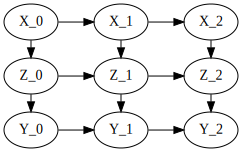

In [3]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_nonstat_scm(T=T)
dag_view

Unlike the DAG used for the STAT. example (figure 1 in paper) we need to modify the structure of this DAG to represent the non-stationary evolution of the SEM used in the example.

In [4]:
# Simple networkx syntax is used to manipulate an object
dag.add_edge('X_0','Z_1')
dag.add_edge('Z_1','Y_2')

# We print out the edge set just to make sure they have been properly added
dag.edges

OutMultiEdgeView([('X_0', 'Z_0', 0), ('X_0', 'X_1', 0), ('X_0', 'Z_1', 0), ('Z_0', 'Y_0', 0), ('Z_0', 'Z_1', 0), ('Y_0', 'Y_1', 0), ('X_1', 'Z_1', 0), ('X_1', 'X_2', 0), ('Z_1', 'Y_1', 0), ('Z_1', 'Z_2', 0), ('Z_1', 'Y_2', 0), ('Y_1', 'Y_2', 0), ('X_2', 'Z_2', 0), ('Z_2', 'Y_2', 0)])

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [5]:
type(dag)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [6]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Z_0; Z_0 -> Y_0; X_1 -> Z_1; Z_1 -> Y_1; X_2 -> Z_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }


**OBS. that the `dag_view` will not show our added edges as the object was generated before we modified the topology**

Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

## Other setup parameters 

In [7]:
# Contains the exploration sets we will be investigating
print("Exploration sets:", exploration_sets)
# The intervention domains for the manipulative variables
print("Intervention domains:", intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print("True optimal outcome values:", [r"y^*_{} = {}".format(t,val.round(3)) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 10

Exploration sets: [('X',), ('Z',), ('X', 'Z')]
Intervention domains: {'X': [-4, 1], 'Z': [-3, 3]}
True optimal outcome values: ['y^*_0 = 4.317', 'y^*_1 = -8.329', 'y^*_2 = 12.387']


## Explore optimization methods

Unlike the demo in `stat_scm.ipynb` here we are going to demonstrate the replicate method as used to generate the results in the paper. In all these examples we do not employ any interventional data, just observational.

In [12]:
# See method for argument details
change_points = T*[False]
change_points[1] = True # We encode where the time-series changes stationary regime
R = 3
results = run_methods_replicates(G=dag, 
                                sem=NonStatSEM, 
                                make_sem_estimator=auto_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['DCBO', 'CBO', 'ABO', 'BO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=True,
                                change_points=change_points)

Experiment count:   0%|          | 0/3 [00:00<?, ?it/s]


	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
 ../src/utils/sem_utils/toy_sems.py:158: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.709725935236852
Optimization restart 1/1, f = 5.671133447774524
Optimization restart 1/1, f = 5.944357316009758
Optimization restart 1/1, f = 7.140823976520185


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.965699671391487


Optimization restart 1/1, f = 5.049220152680494


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.120809712062169
Optimization restart 1/1, f = 7.787410852684185
Optimization restart 1/1, f = 7.408869270530255
Optimization restart 1/1, f = 6.64403892807954
Optimization restart 1/1, f = 10.328745690209294


Optimization restart 1/1, f = 9.982123111284528


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 7.013337399166872
Optimization restart 1/1, f = 8.71452006136903
Optimization restart 1/1, f = 10.130437322967389
Optimization restart 1/1, f = 6.459679149647369
Optimization restart 1/1, f = 9.33242785576319


Time index: 100%|██████████| 3/3 [00:23<00:00,  7.91s/it]

Optimization restart 1/1, f = 11.842489396046677

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.502633635868555
Optimization restart 1/1, f = 9.35001468514117
Optimization restart 1/1, f = 5.789131830120601
Optimization restart 1/1, f = 8.044689263410058
Optimization restart 1/1, f = 7.1861577948127
Optimization restart 1/1, f = 6.687335022647204
Optimization restart 1/1, f = 4.946682295422846
Optimization restart 1/1, f = 3.7839744418375627
Optimization restart 1/1, f = 0.0950918391701272
Optimization restart 1/1, f = 39.51892257377118
Optimization restart 1/1, f = 42.260864326159336

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 43.80732060380305
Optimization restart 1/1, f = 43.028145791140965
Optimization restart 1/1, f = 47.004711516576045
Optimization restart 1/1, f = 49.97109016969686
Optimization restart 1/1, f = 51.70511778665271
Optimization restart 1/1, f = 54.64639934928736
Optimization restart 1/1, f = 57.659349558457386
Optimization restart 1/1, f = 70.3622483366307


Time index: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

Optimization restart 1/1, f = 73.46792351343055
Optimization restart 1/1, f = 76.98733041062081
Optimization restart 1/1, f = 81.2014138839288
Optimization restart 1/1, f = 84.94625902822993
Optimization restart 1/1, f = 88.51830980482971
Optimization restart 1/1, f = 91.43667662498677
Optimization restart 1/1, f = 94.97141261024669
Optimization restart 1/1, f = 97.94930424209491

	>>>BO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.502633635868555
Optimization restart 1/1, f = 9.35001468514117
Optimization restart 1/1, f = 5.789131830120601
Optimization restart 1/1, f = 8.044689263410058
Optimization restart 1/1, f = 7.1861577948127
Optimization restart 1/1, f = 6.687335022647204
Optimization restart 1/1, f = 4.946682295422846
Optimization restart 1/1, f = 3.7839744418375627
Optimization restart 1/1, f = 0.0950918391701272
Optimization restart 1/1, f = 5.69932077655892
Optimization restart 1/1, f = 6.631965034977608
Optimization restart 1/1, f = 8.429439565747554


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 13.106163755320843
Optimization restart 1/1, f = 18.389246473412243
Optimization restart 1/1, f = 20.04951973934862
Optimization restart 1/1, f = 23.12281197524544
Optimization restart 1/1, f = 29.40126373817995
Optimization restart 1/1, f = 31.647495804664327
Optimization restart 1/1, f = 14.64807401233823
Optimization restart 1/1, f = 22.000195188393448


Experiment count:  33%|███▎      | 1/3 [00:57<01:55, 57.69s/it]

Optimization restart 1/1, f = 23.67056928829456
Optimization restart 1/1, f = 25.936160178206084
Optimization restart 1/1, f = 26.859010387202304
Optimization restart 1/1, f = 30.071543958521666
Optimization restart 1/1, f = 32.24323217288348
Optimization restart 1/1, f = 34.74497127838251
Optimization restart 1/1, f = 36.899766728593626

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.726198892126531
Optimization restart 1/1, f = 5.676557290189831
Optimization restart 1/1, f = 5.9904458578077655


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.928713344163141
Optimization restart 1/1, f = 3.107066799302636


Optimization restart 1/1, f = 7.1848744579704915


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 7.9187243015084965
Optimization restart 1/1, f = 7.00618477129275
Optimization restart 1/1, f = 7.464510490751724
Optimization restart 1/1, f = 7.992613860046257
Optimization restart 1/1, f = 11.975623536616125


Optimization restart 1/1, f = 10.648698098057704


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.50391525849625
Optimization restart 1/1, f = 7.187623327347894
Optimization restart 1/1, f = 8.073653592212123
Optimization restart 1/1, f = 8.690248073895958
Optimization restart 1/1, f = 10.055428583852006


Time index: 100%|██████████| 3/3 [00:25<00:00,  8.66s/it]

Optimization restart 1/1, f = 11.145511455760019

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.371452523501937
Optimization restart 1/1, f = 10.066560757247888
Optimization restart 1/1, f = 10.889780970777846
Optimization restart 1/1, f = 12.766959106812587
Optimization restart 1/1, f = 11.25604031984731
Optimization restart 1/1, f = 10.616428812705248
Optimization restart 1/1, f = 6.458279868977906
Optimization restart 1/1, f = 3.202166337549773
Optimization restart 1/1, f = 3.9959563663648243
Optimization restart 1/1, f = 42.19314473485852
Optimization restart 1/1, f = 43.48205316831499
Optimization restart 1/1, f = 45.25836779400599
Optimization restart 1/1, f = 49.94712854526963
Optimization restart 1/1, f = 53.495769567994614
Optimization restart 1/1, f = 55.44131634497219
Optimization restart 1/1, f = 58.27721116111331
Optimization restart 1/1, f = 60.15040532279383


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 62.54578927797177
Optimization restart 1/1, f = 73.3895380824113
Optimization restart 1/1, f = 78.34348930927322
Optimization restart 1/1, f = 81.95219758742924
Optimization restart 1/1, f = 85.29545419806475


Time index: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

Optimization restart 1/1, f = 88.45540098205973
Optimization restart 1/1, f = 92.23462373123544
Optimization restart 1/1, f = 96.20974540259847
Optimization restart 1/1, f = 99.7629431114118
Optimization restart 1/1, f = 103.36648992814493

	>>>BO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.371452523501937
Optimization restart 1/1, f = 10.066560757247888
Optimization restart 1/1, f = 10.889780970777846
Optimization restart 1/1, f = 12.766959106812587
Optimization restart 1/1, f = 11.25604031984731
Optimization restart 1/1, f = 10.616428812705248
Optimization restart 1/1, f = 6.458279868977906
Optimization restart 1/1, f = 3.202166337549773
Optimization restart 1/1, f = 3.9959563663648243
Optimization restart 1/1, f = 10.343028725740917

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 12.00479451602694
Optimization restart 1/1, f = 13.66231743775395
Optimization restart 1/1, f = 17.03434951249775
Optimization restart 1/1, f = 20.015108453933188
Optimization restart 1/1, f = 21.39514777817615
Optimization restart 1/1, f = 23.470651213227036
Optimization restart 1/1, f = 24.766998403445367
Optimization restart 1/1, f = 27.8879963992886


Experiment count:  67%|██████▋   | 2/3 [02:01<01:01, 61.40s/it]

Optimization restart 1/1, f = 9.419804859411562
Optimization restart 1/1, f = 14.597868660132
Optimization restart 1/1, f = 17.253104036938797
Optimization restart 1/1, f = 20.261762991435056
Optimization restart 1/1, f = 23.111430888634892
Optimization restart 1/1, f = 24.145718010740765
Optimization restart 1/1, f = 24.796801184677484
Optimization restart 1/1, f = 26.498846304573306
Optimization restart 1/1, f = 25.972697390116267

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.636371607739999
Optimization restart 1/1, f = 5.694220166492334
Optimization restart 1/1, f = 6.005663271663826


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.984754354773667
Optimization restart 1/1, f = 7.294088528404245


Optimization restart 1/1, f = 5.910231203611942


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 8.093073081832765
Optimization restart 1/1, f = 6.813287679322762
Optimization restart 1/1, f = 6.747784756967654
Optimization restart 1/1, f = 11.458991639438615
Optimization restart 1/1, f = 9.981731507420355


Optimization restart 1/1, f = 11.327953603297162


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning:overflow encountered in double_scalars


Optimization restart 1/1, f = 6.998410875089691
Optimization restart 1/1, f = 6.480605693805245
Optimization restart 1/1, f = 7.337289179812959
Optimization restart 1/1, f = 7.240061490863864
Optimization restart 1/1, f = 6.677459359664505


Time index: 100%|██████████| 3/3 [00:27<00:00,  9.27s/it]

Optimization restart 1/1, f = 8.102367872478666

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.5106357281513
Optimization restart 1/1, f = 9.892597310926494
Optimization restart 1/1, f = 11.891887377886203
Optimization restart 1/1, f = 10.821371630753678
Optimization restart 1/1, f = 10.845729449459164
Optimization restart 1/1, f = 10.394540358225619
Optimization restart 1/1, f = 9.782237085466257
Optimization restart 1/1, f = 7.336732226253941
Optimization restart 1/1, f = 4.374998847189831
Optimization restart 1/1, f = 43.93042767888271
Optimization restart 1/1, f = 47.29145957440801

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 49.85230307815756
Optimization restart 1/1, f = 51.7346756844963
Optimization restart 1/1, f = 53.994240002474065
Optimization restart 1/1, f = 57.40872192722287
Optimization restart 1/1, f = 60.96345921269303
Optimization restart 1/1, f = 62.12041759437943
Optimization restart 1/1, f = 63.78510559237134
Optimization restart 1/1, f = 80.90260263755683

Time index: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


Optimization restart 1/1, f = 86.0871397058698
Optimization restart 1/1, f = 91.47986857809505
Optimization restart 1/1, f = 95.80025609005581
Optimization restart 1/1, f = 101.14841906491893
Optimization restart 1/1, f = 106.22798229006388
Optimization restart 1/1, f = 110.75315714076218
Optimization restart 1/1, f = 115.08082363000838
Optimization restart 1/1, f = 118.12988597117932

	>>>BO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.5106357281513
Optimization restart 1/1, f = 9.892597310926494
Optimization restart 1/1, f = 11.891887377886203
Optimization restart 1/1, f = 10.821371630753678
Optimization restart 1/1, f = 10.845729449459164
Optimization restart 1/1, f = 10.394540358225619
Optimization restart 1/1, f = 9.782237085466257
Optimization restart 1/1, f = 7.336732226253941
Optimization restart 1/1, f = 4.374998847189831


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.563210246869021
Optimization restart 1/1, f = 9.918238528773564
Optimization restart 1/1, f = 11.260474176777961
Optimization restart 1/1, f = 18.613549061583385
Optimization restart 1/1, f = 20.901417430464058
Optimization restart 1/1, f = 24.050388458436363
Optimization restart 1/1, f = 26.26717388131077
Optimization restart 1/1, f = 28.415947203028107
Optimization restart 1/1, f = 31.879503143130904
Optimization restart 1/1, f = 10.530970652799525
Optimization restart 1/1, f = 12.787864809774236
Optimization restart 1/1, f = 16.209720122864947

Experiment count: 100%|██████████| 3/3 [03:03<00:00, 61.29s/it]


Optimization restart 1/1, f = 17.196038320849492
Optimization restart 1/1, f = 22.596165205032435
Optimization restart 1/1, f = 23.083045837839936
Optimization restart 1/1, f = 24.760494005820032
Optimization restart 1/1, f = 24.155586575290418
Optimization restart 1/1, f = 23.291510991281985


## Analyse results and plot

In [42]:
from src.experimental.analyse_results import get_relevant_results, elaborate
from src.utils.plotting import plot_expected_opt_curve_paper
from matplotlib.pyplot import rc

In [33]:
# Since we didn't save the results we cannot use the pickled file so we have to convert results to the correct format
data = get_relevant_results(results=results,replicates=R)
exp_optimal_outcome_values_during_trials, exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

### Plot results

In [57]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCBO': 'DCBO', 'CBO': 'CBO', 'ABO': 'ABO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCBO': 'blue', 'CBO': 'green', 'ABO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCBO': '-', 'CBO': '--', 'ABO': 'dashdot', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

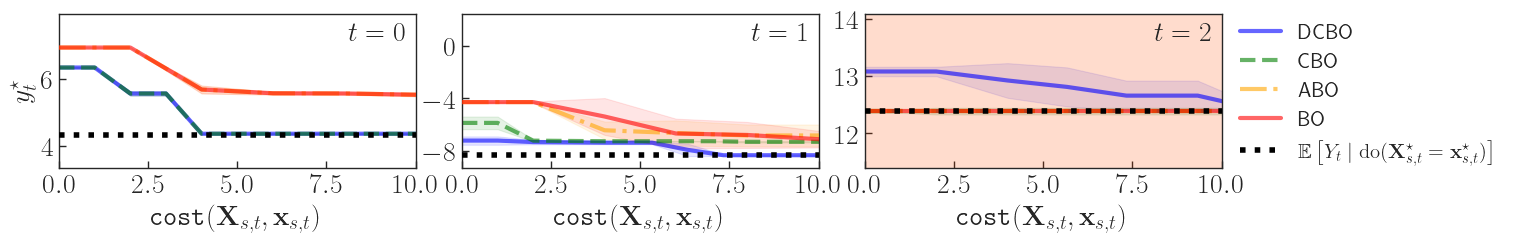

In [59]:
# Here we demonstrate how to use the plot functionality as used in the paper. Each frame corresponds to one time-slice. As we have only run each model for ten trials, we do not expect stellar results (see final frame).
plot_expected_opt_curve_paper(T,
    true_objective_values,
    exp_per_trial_cost,
    exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,2))